In [15]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np 
import matplotlib.pyplot as plt

from astropy.io import fits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import bagpipes as bp 

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


#### Bagpipes Demos 

- [Example 1 - Making model galaxies](https://github.com/ACCarnall/bagpipes/blob/master/examples/Example%201%20-%20Making%20model%20galaxies.ipynb)
- [Example 2 - Loading observational data](https://github.com/ACCarnall/bagpipes/blob/master/examples/Example%202%20-%20Loading%20observational%20data.ipynb)
- [Example 3 - Fitting photometric data with a simple model](https://github.com/ACCarnall/bagpipes/blob/master/examples/Example%203%20-%20Fitting%20photometric%20data%20with%20a%20simple%20model.ipynb)

#### References

- [Making model spectra: model_galaxy](https://bagpipes.readthedocs.io/en/latest/model_galaxies.html)
- [The model_components dictionary](https://bagpipes.readthedocs.io/en/latest/model_components.html)
- [Loading observational data: galaxy](https://bagpipes.readthedocs.io/en/latest/loading_galaxies.html)

### Making a simple model spectrum

In [3]:
exp = {"age": 3., "tau": 0.75, "massformed": 10., "metallicity": 0.5}

dust = {"type": "Calzetti", "Av": 0.1}

model_components = {"redshift": 0.4, "exponential": exp, "dust": dust}

In [4]:
goodss_filt_list = ["filters/VIMOS_U",
                    "filters/f435w",
                    "filters/f606w",
                    "filters/f775w",
                    "filters/f850lp",
                    "filters/f098m",
                    "filters/f105w",
                    "filters/f125w",
                    "filters/f160w",
                    "filters/ISAAC_Ks",
                    "filters/HAWKI_K",
                    "filters/IRAC1",
                    "filters/IRAC2",
                    "filters/IRAC3",
                    "filters/IRAC4"]

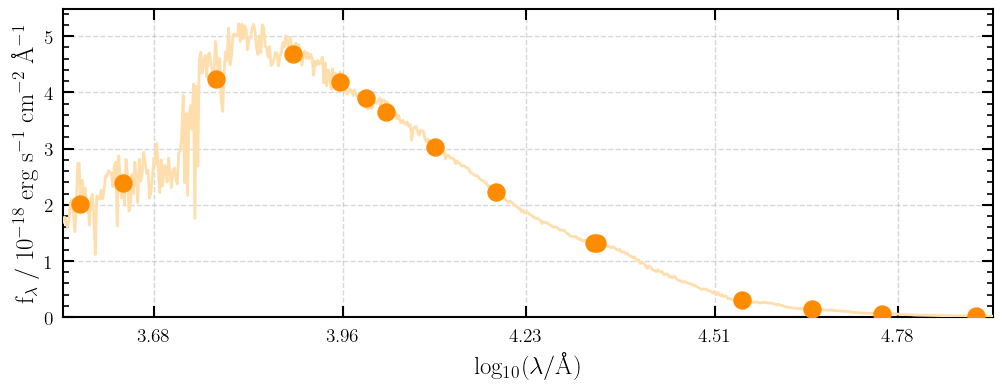

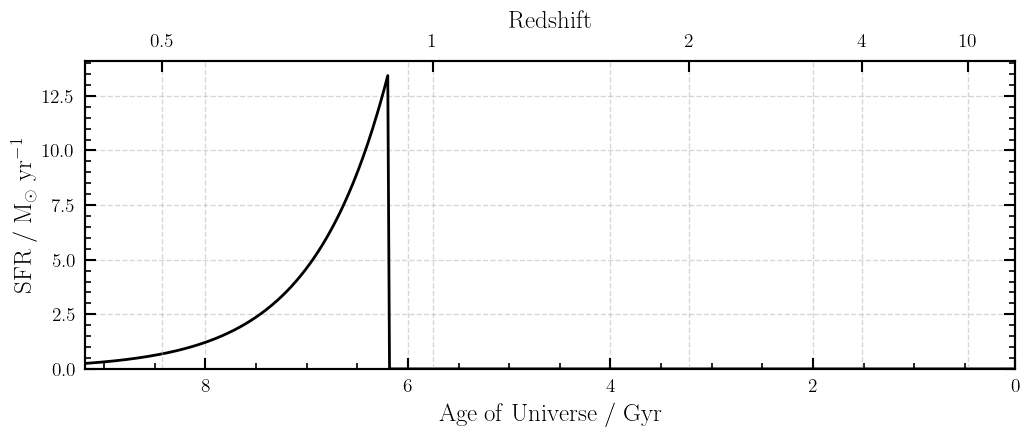

In [7]:
model = bp.model_galaxy(model_components, filt_list=goodss_filt_list)

fig = model.plot()
fig = model.sfh.plot()

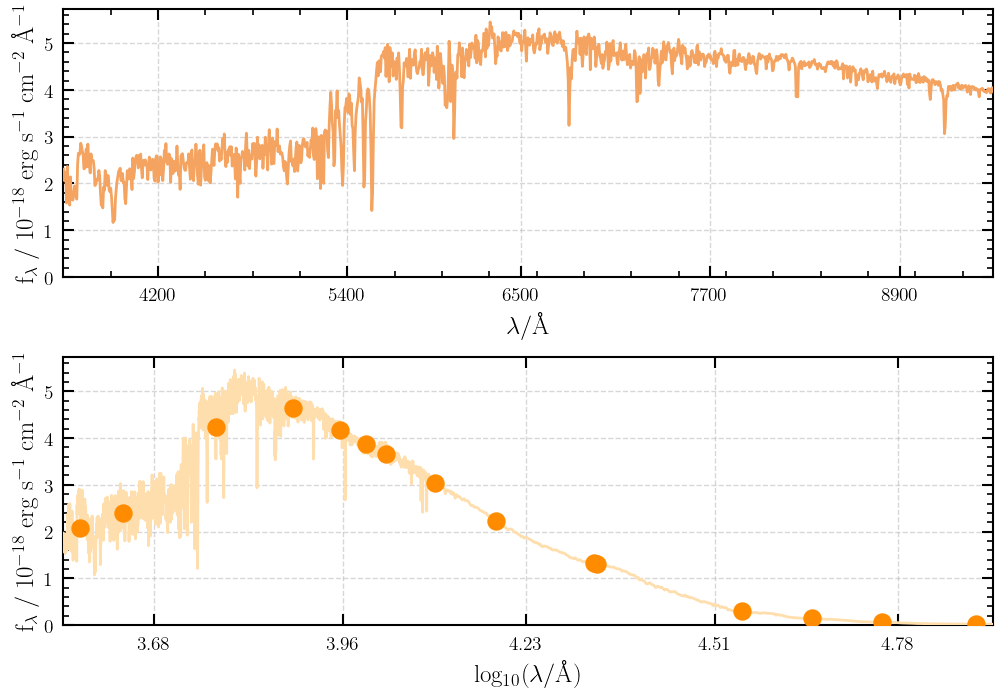

In [9]:
model = bp.model_galaxy(
    model_components, filt_list=goodss_filt_list, 
    spec_wavs=np.arange(3600., 9500., 5.))

fig = model.plot()

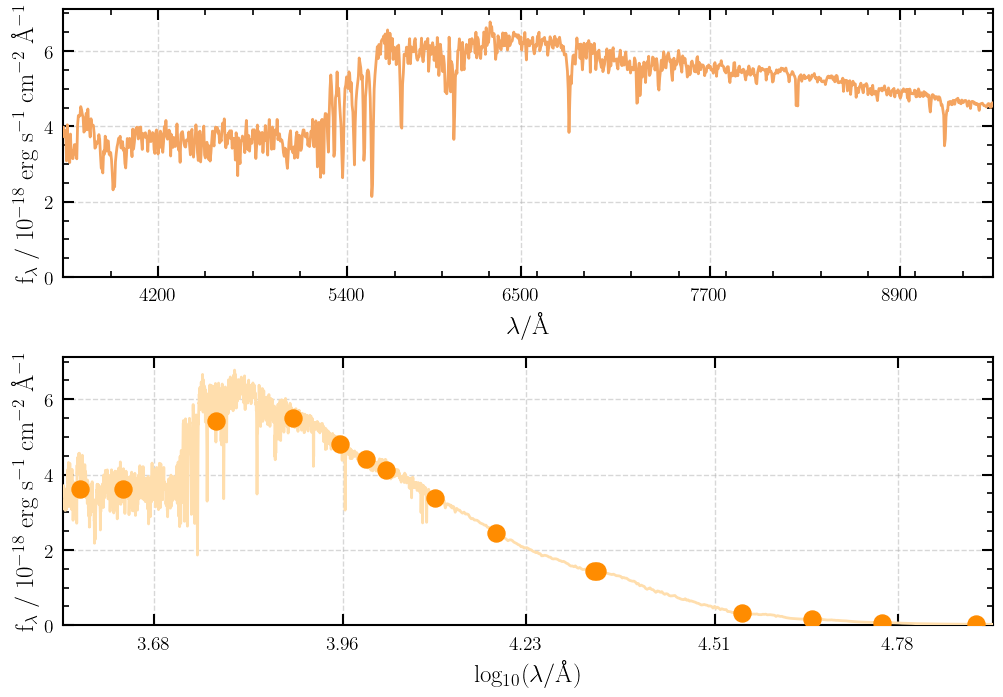

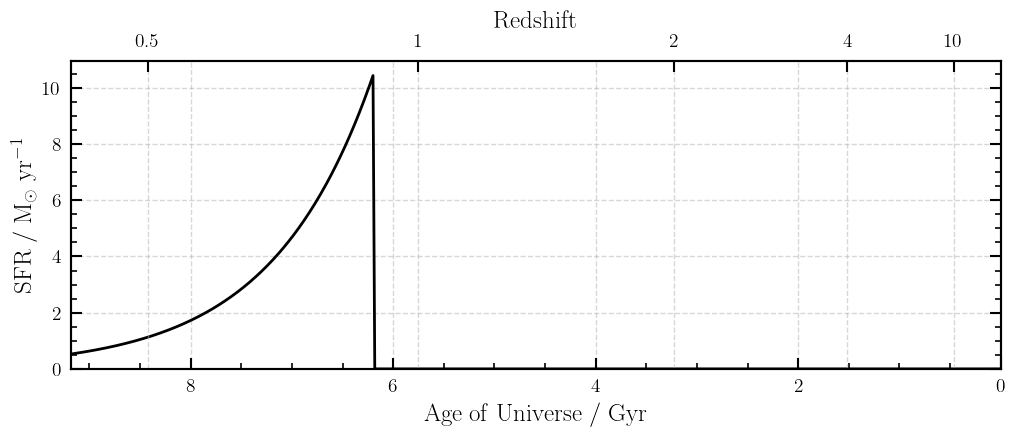

In [10]:
exp["tau"] = 1.0

model.update(model_components)

fig = model.plot()
fig = model.sfh.plot()

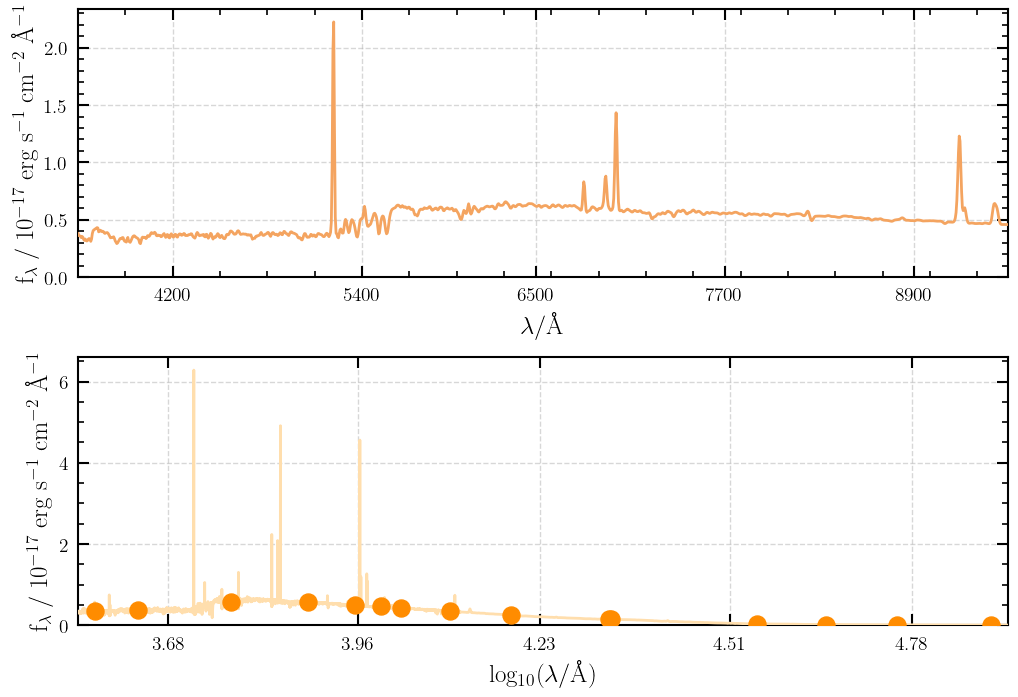

In [12]:
nebular = {"logU": -3}

dust["eta"] = 3.    # Extra dust for young stars: multiplies Av

model_components["t_bc"] = 0.01         # Lifetime of birth clouds (Gyr)
model_components["veldisp"] = 300.      # km/s
model_components["nebular"] = nebular

model = bp.model_galaxy(
    model_components, filt_list=goodss_filt_list, 
    spec_wavs=np.arange(3600., 9500., 5.)
)

fig = model.plot()

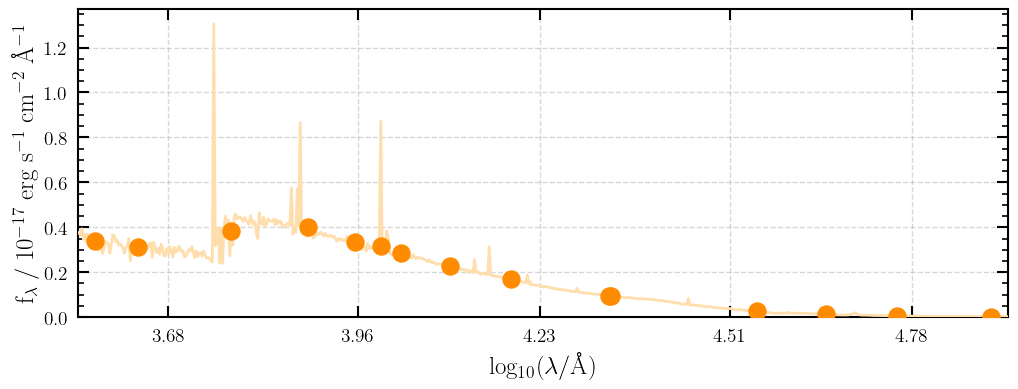

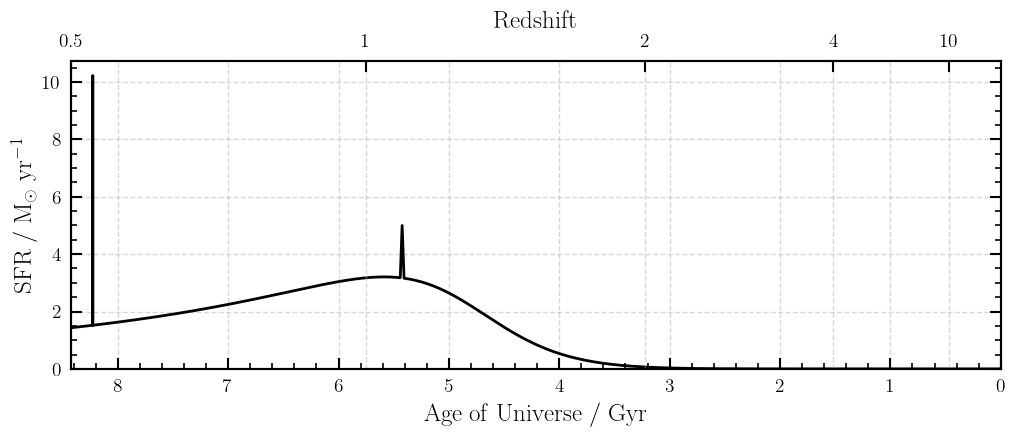

In [13]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             

dblplaw = {}
dblplaw["tau"] = 5.
dblplaw["alpha"] = 2.5
dblplaw["beta"] = 10.
dblplaw["massformed"] = 10.
dblplaw["metallicity"] = 0.5

burst1 = {}
burst1["age"] = 0.2
burst1["massformed"] = 7.
burst1["metallicity"] = 1.

burst2 = {}
burst2["age"] = 3.
burst2["massformed"] = 7.5
burst2["metallicity"] = 0.2

model_components = {}                   
model_components["redshift"] = 0.5
model_components["t_bc"] = 0.01         
model_components["veldisp"] = 200. 
model_components["burst1"] = burst1
model_components["burst2"] = burst2
model_components["dblplaw"] = dblplaw
model_components["dust"] = dust
model_components["nebular"] = nebular

model = bp.model_galaxy(model_components, filt_list=goodss_filt_list)

fig = model.plot()
sfh = model.sfh.plot()

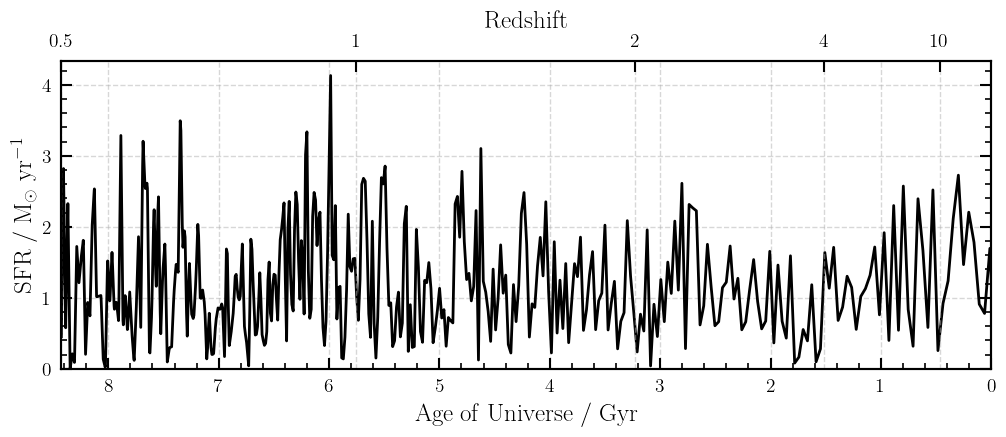

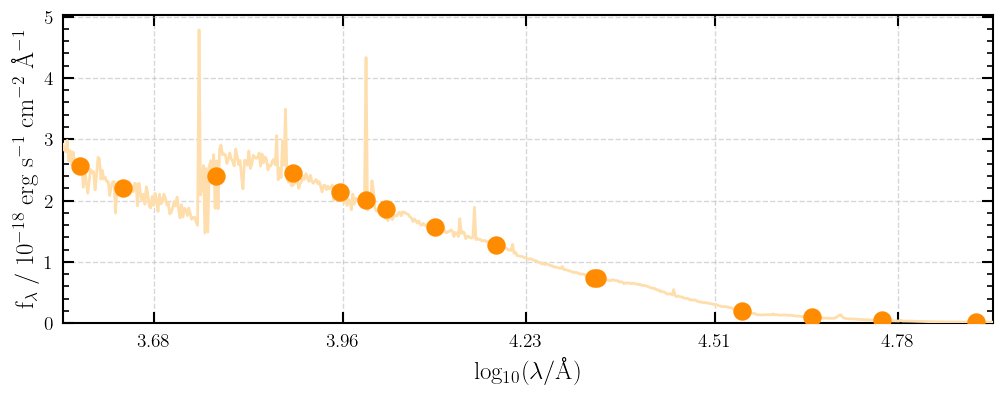

In [14]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             

sfh = np.zeros((500, 2))
sfh[:, 0] = np.arange(0., 10., 0.02)*10**9
sfh[:, 1] = np.abs(np.random.randn(500))

custom = {}
custom["history"] = sfh
custom["massformed"] = 10.
custom["metallicity"] = 1.

model_components = {}                   
model_components["redshift"] = 0.5
model_components["t_bc"] = 0.01         
model_components["veldisp"] = 200. 
model_components["custom"] = custom
model_components["dust"] = dust
model_components["nebular"] = nebular

model = bp.model_galaxy(model_components, filt_list=goodss_filt_list)

sfh = model.sfh.plot()
fig = model.plot()

### Loading observational data into Bagpipes

In [22]:
def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("/Users/song/Downloads/hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9 * 10 ** 99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0] / photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0] / max_snr

    return photometry

In [24]:
load_goodss("17432")

array([[-5.03570e-04,  1.63660e-03],
       [ 8.89472e-03,  2.12797e-03],
       [ 1.27466e-02,  1.38684e-03],
       [ 2.43217e-02,  1.65038e-03],
       [ 3.08856e-02,  2.95342e-03],
       [ 0.00000e+00,  9.90000e+99],
       [ 5.57840e-02,  2.78920e-03],
       [ 4.49790e-02,  2.24895e-03],
       [ 4.23690e-02,  2.29299e-03],
       [ 8.64122e-02,  8.83163e-02],
       [ 1.06555e-01,  2.14006e-02],
       [ 1.25895e-01,  1.21269e-01],
       [ 6.27395e-02,  8.26907e-02],
       [-3.98963e-01,  3.33661e-01],
       [ 3.96450e-03,  3.90640e-01]])

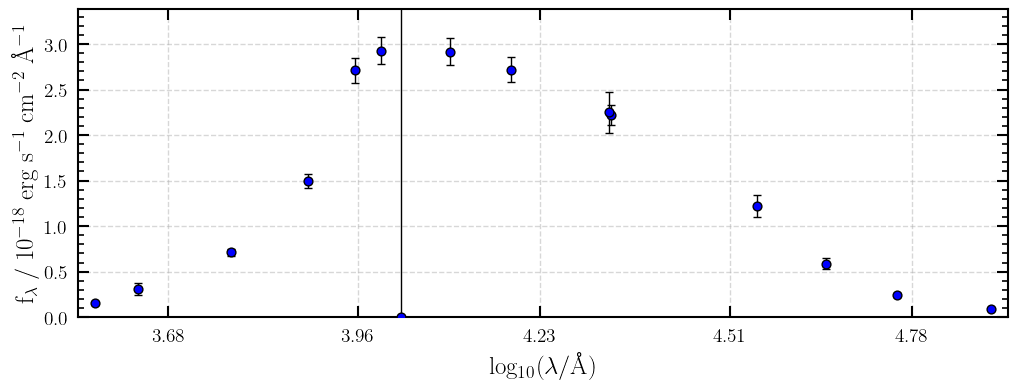

In [25]:
galaxy = bp.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)

fig = galaxy.plot()

#### Load spectroscopic data

In [29]:
def load_vandels_spec(ID):
    """ Loads VANDELS spectroscopic data from file. """

    hdulist = fits.open("/Users/song/Downloads/VANDELS_CDFS_" + ID + ".fits")

    spectrum = np.c_[hdulist[1].data["WAVE"][0],
                     hdulist[1].data["FLUX"][0],
                     hdulist[1].data["ERR"][0]]

    mask = (spectrum[:,0] < 9250.) & (spectrum[:,0] > 5250.)

    return bin(spectrum[mask], 2)


def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum) // binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_both(ID):
    spectrum = load_vandels_spec(ID)
    phot = load_goodss(ID)

    return spectrum, phot

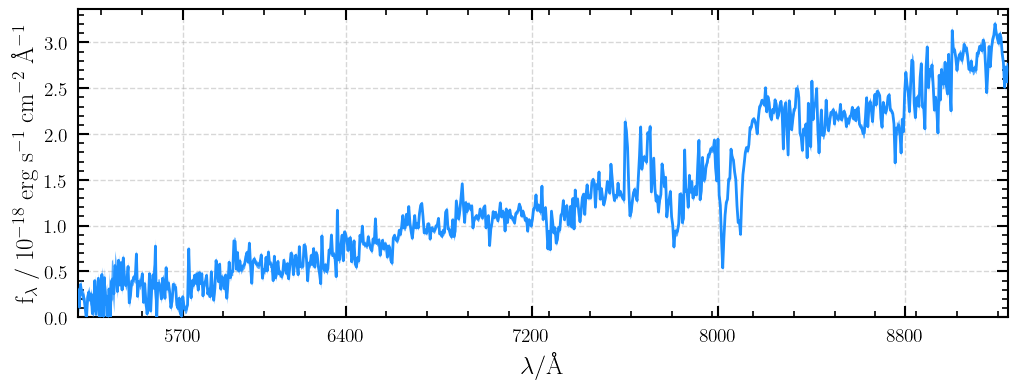

In [33]:
galaxy = bp.galaxy("017433", load_vandels_spec, photometry_exists=None)

fig = galaxy.plot()

### Fitting Photometric Data

In [34]:
galaxy = bp.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
